In [1]:
"""
Title: PixelCNN
Author: [ADMoreau](https://github.com/ADMoreau)
Date created: 2020/05/17
Last modified: 2020/05/23
Description: PixelCNN implemented in Keras.
"""

"""
## Introduction
PixelCNN is a generative model proposed in 2016 by van den Oord et al.
(reference: [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)).
It is designed to generate images (or other data types) iteratively
from an input vector where the probability distribution of prior elements dictates the
probability distribution of later elements. In the following example, images are generated
in this fashion, pixel-by-pixel, via a masked convolution kernel that only looks at data
from previously generated pixels (origin at the top left) to generate later pixels.
During inference, the output of the network is used as a probability ditribution
from which new pixel values are sampled to generate a new image
(here, with MNIST, the pixels values are either black or white).
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from keras.callbacks import History
import sfh
from sfh.model_utils import input_fn, predictor, pass_sample, finish_sample
history = History()
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
print(tfp.__version__)


%pylab inline

#  Important !!!! path to shared tensorflow dataset
data_dir='/var/home/laatu/tensorflow_datasets'

[]
2.8.0-dev20211208
0.15.0
Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow_datasets as tfds
dset = tfds.load('sfh_interp', split='train', data_dir=data_dir)
sample = list(dset.take(5))[3]

num_components = 2
# Shape of the distribution
event_shape = [1]
# Utility function to compute how many parameters this distribution requires
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
print(params_size)

6


In [3]:


def preprocessing(example):
    
    return tf.reshape(tf.cast(example['SFR_Max'], dtype=tf.float32),(-1,100,1)), \
           tf.reshape(tf.cast(example['SFR_Max'], dtype=tf.float32),(-1,100,1))

def input_fn(mode='train', batch_size=64, dataset_name='sfh', data_dir=None):
    """
    mode: 'train' or 'test'
    """
    if mode == 'train':
        dataset = tfds.load(dataset_name, split='train[:80%]', data_dir=data_dir)
        #dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load(dataset_name, split='train[80%:]', data_dir=data_dir)
    
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1)       # fetch next batches while training current one (-1 for autotune)
    return dataset, tf.data.experimental.cardinality(dset).numpy()

def predictor(model, sample_size, nsteps=100):
    res = np.zeros((sample_size, nsteps,1))
    for i in range(nsteps):
        tmp = model(res).sample()
        res[0,i] = tmp[0,i]
    return res

def pass_sample(model, sample, n_pass=100):
    sample = tf.reshape(sample,(1, 100, 1))
    mean = model(sample).mean()
    std = model(sample).stddev()
    p_sample = model(sample).sample()
    return mean, std, p_sample

In [4]:
from sfh.models.pixelcnn_res import generate_model
pixel_cnn = generate_model()

In [18]:

import sfh
import importlib
importlib.reload(tfds)

[autoreload of tensorflow_datasets.core failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/__init__.py", line 44, in <module>

[autoreload of tensorflow_datasets.core.dataset_info failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/dataset_info.py", lin

[autoreload of tensorflow_datasets.testing failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/testing/__init__.py", line 26, in <m

[autoreload of tensorflow_datasets.audio.savee failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", 

[autoreload of tensorflow_datasets.image.aflw2k3d failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py

[autoreload of tensorflow_datasets.image_classification.chexpert failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/u

[autoreload of tensorflow_datasets.image_classification.imagenet2012_multilabel.imagenet2012_multilabel failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/s

[autoreload of tensorflow_datasets.image_classification.inaturalist failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/cor

[autoreload of tensorflow_datasets.image_classification.siscore.siscore failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets

[autoreload of tensorflow_datasets.image.celeba failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py",

[autoreload of tensorflow_datasets.object_detection.kitti failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/ve

[autoreload of tensorflow_datasets.d4rl.d4rl_adroit_hammer.d4rl_adroit_hammer failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_da

[autoreload of tensorflow_datasets.structured.movielens failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/vers

[autoreload of tensorflow_datasets.summarization.billsum failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/ver

[autoreload of tensorflow_datasets.summarization.summscreen.summscreen failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/

[autoreload of tensorflow_datasets.text.movie_rationales failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/ver

[autoreload of tensorflow_datasets.text.schema_guided_dialogue.schema_guided_dialogue failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tenso

[autoreload of tensorflow_datasets.text.wikiann.wikiann failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/vers

[autoreload of tensorflow_datasets.translate.ted_multi failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/version.py", line 113, in __eq__
    other = self._validate_operand(other)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/core/utils/versi

<module 'tensorflow_datasets' from '/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/site-packages/tensorflow_datasets/__init__.py'>

In [26]:
import tensorflow_datasets as tfds

In [8]:
tfds.__version__

'4.4.0'

In [179]:
importlib.reload(sfh)
pixel_cnn = sfh.models.pixelcnn_res.generate_model(kernel_size=2, optimizer=tf.keras.optimizers.Adam(0.0001))
pixel_cnn.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 masked_conv_layer_6 (MaskedCon  (None, 100, 16)     64          ['input_12[0][0]']               
 vLayer)                                                                                          
                                                                                                  
 conv1d_72 (Conv1D)             (None, 100, 32)      1568        ['masked_conv_layer_6[0][0]']    
                                                                                                  
 conv1d_74 (Conv1D)             (None, 100, 32)      544         ['masked_conv_layer_6[0][0

In [4]:
batch_size = 64
epochs = 50

dtrain, num_train = input_fn(mode='train', batch_size=batch_size, dataset_name='sfh')
dval, num_val = input_fn(mode='val', batch_size=batch_size, dataset_name='sfh')

In [ ]:
del hist

In [180]:


hist = pixel_cnn.fit(dtrain, 
                     epochs=epochs, 
                     #steps_per_epoch=num_train//batch_size, 
                     validation_data=dval,
                     callbacks=[history])

Epoch 1/50
269/269 [==============================] - 15s 51ms/step - loss: 274.2736 - val_loss: 178.0083
Epoch 2/50
269/269 [==============================] - 13s 50ms/step - loss: 169.5669 - val_loss: 129.8211
Epoch 3/50
269/269 [==============================] - 14s 50ms/step - loss: 121.5487 - val_loss: 98.0448
Epoch 4/50
269/269 [==============================] - 13s 49ms/step - loss: 71.9056 - val_loss: 31.0313
Epoch 5/50
269/269 [==============================] - 13s 50ms/step - loss: 5.8298 - val_loss: -7.8580
Epoch 6/50
269/269 [==============================] - 14s 50ms/step - loss: -13.6342 - val_loss: -20.1384
Epoch 7/50
269/269 [==============================] - 14s 50ms/step - loss: -24.9216 - val_loss: -29.9169
Epoch 8/50
269/269 [==============================] - 13s 49ms/step - loss: -32.3951 - val_loss: -32.8808
Epoch 9/50
269/269 [==============================] - 13s 49ms/step - loss: -37.9756 - val_loss: -40.9344
Epoch 10/50
269/269 [==============================]

# vae

In [305]:
def get_probabilistic_encoder():
    """ Creates a small convolutional encoder for the requested latent dimension
    """
    # We choose a prior distribution for the latent codes
    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))

    return tf.keras.Sequential([ 
      tfkl.Input(shape=(100,1)),
      tfkl.Conv1D(32, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=2, padding='same'), 
      # Image is now 32x32x32
      tfkl.Conv1D(64, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=4, padding='same'),
      # Image is now 16x16x64
      tfkl.Conv1D(128, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=8, padding='same'),
      # Image is now 8x8x128
      tfkl.Conv1D(256, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=16, padding='same'),
      # Image is now 4x4x256
      tfkl.Flatten(),
      tfkl.Dense(512, activation=tf.nn.leaky_relu)])


def get_image_encoder():
    """ Creates a small convolutional encoder for the requested latent dimension
    """
    # We choose a prior distribution for the latent codes
    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))

    return tf.keras.Sequential([ 
      tfkl.Input(shape=(64,64,5)),
      tfkl.Conv2D(32, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'), 
      tfkl.Conv2D(64, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'),
      tfkl.Conv2D(128, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'),
      tfkl.Conv2D(256, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'),
      tfkl.Conv2D(512, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=1, padding='same'),
      tfkl.Flatten(),
      tfkl.Dense(512, activation=tf.nn.leaky_relu)])
      
      
def return_probabilistic(latent_dim=32):
  
    
    return tf.keras.Sequential([ 
      # We ask this layer to output a vector of size equal to the number of
      # parameters required to define a Multivariate Gaussian
      tfkl.Input(shape=(100,1)),
        
      tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
      # At the last layer, we ask the model to output a **distribution**
      # In this case, a Multivariate Normal
      tfpl.MultivariateNormalTriL(latent_dim, 
              # And we specify a regularization for this distribution, used
              # during training, we want the KL divergence with the prior 
              # to be small, i.e. the encoded distribution should be close to a 
              # standard Gaussian
              activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
              )
      ])

In [307]:
import tensorflow_probability as tfp
tfpl = tfp.layers
tfkl = tf.keras.layers
tfd = tfp.distributions

latent_dim = 16
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))




#latent_dim=latent_dim
#prob_encoder = get_probabilistic_encoder()
#prob_encoder.summary()

image_inputs = tf.keras.Input(shape=(64,64,5), dtype='float32')
x = tfkl.Conv2D(32, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(image_inputs)
x = tfkl.Conv2D(64, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Conv2D(128, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Conv2D(256, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Conv2D(512, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same')(x)
x = tfkl.Flatten()(x)
x = tfkl.Dense(512, activation=tf.nn.leaky_relu)(x)
image_out = tf.keras.layers.Dense(params_size)(x)

test = keras.Model(image_inputs, image_out)

test.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 64, 64, 5)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        1472      
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_18 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 conv2d_19 (Conv2D)          (None, 2, 2, 512)         1180160   
                                                                 
 flatten_14 (Flatten)        (None, 2048)              0     

In [309]:




sfr_inputs = tf.keras.Input(shape=(100,1), dtype='float32')
y = tfkl.Conv1D(32, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=2, padding='same')(sfr_inputs)

y = tfkl.Conv1D(64, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=4, padding='same')(y)

y = tfkl.Conv1D(128, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=8, padding='same')(y)

y = tfkl.Conv1D(256, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=16, padding='same')(y)

y = tfkl.Flatten()(y)
sfr_out = tfkl.Dense(512, activation=tf.nn.leaky_relu)(y)


test = keras.Model(sfr_inputs, sfr_out)

test.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 100, 1)]          0         
                                                                 
 conv1d_48 (Conv1D)          (None, 100, 32)           128       
                                                                 
 conv1d_49 (Conv1D)          (None, 100, 64)           6208      
                                                                 
 conv1d_50 (Conv1D)          (None, 100, 128)          24704     
                                                                 
 conv1d_51 (Conv1D)          (None, 100, 256)          98560     
                                                                 
 flatten_16 (Flatten)        (None, 25600)             0         
                                                                 
 dense_47 (Dense)            (None, 512)               1310

In [310]:


concatenated = tf.keras.layers.Concatenate()([sfr_out, image_out])
y = tfkl.Dense(512, activation='relu')(concatenated)
y = tfkl.Dense(128, activation='relu')(y)

y = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim))(y)
# At the last layer, we ask the model to output a **distribution**
# In this case, a Multivariate Normal
z = tfpl.MultivariateNormalTriL(latent_dim, 
      # And we specify a regularization for this distribution, used
      # during training, we want the KL divergence with the prior 
      # to be small, i.e. the encoded distribution should be close to a 
      # standard Gaussian
      activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
      )(y)



In [312]:
import tensorflow_probability as tfp
tfpl = tfp.layers
tfkl = tf.keras.layers
tfd = tfp.distributions

latent_dim = 16

def get_probabilistic_encoder(latent_dim=32):
  """ Creates a small convolutional encoder for the requested latent dimension
  """
  # We choose a prior distribution for the latent codes
  prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))

  return tf.keras.Sequential([ 
      tfkl.Input(shape=(100,1)),
      tfkl.Conv1D(32, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=2, padding='same'), 
      # Image is now 32x32x32
      tfkl.Conv1D(64, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=4, padding='same'),
      # Image is now 16x16x64
      tfkl.Conv1D(128, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=8, padding='same'),
      # Image is now 8x8x128
      tfkl.Conv1D(256, kernel_size=3, activation=tf.nn.leaky_relu, dilation_rate=16, padding='same'),
      # Image is now 4x4x256
      tfkl.Flatten(),
      tfkl.Dense(512, activation=tf.nn.leaky_relu),
      # We ask this layer to output a vector of size equal to the number of
      # parameters required to define a Multivariate Gaussian
      tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
      # At the last layer, we ask the model to output a **distribution**
      # In this case, a Multivariate Normal
      tfpl.MultivariateNormalTriL(latent_dim, 
              # And we specify a regularization for this distribution, used
              # during training, we want the KL divergence with the prior 
              # to be small, i.e. the encoded distribution should be close to a 
              # standard Gaussian
              activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
              )
      ])

prob_encoder = get_probabilistic_encoder(latent_dim=latent_dim)
prob_encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 32)   1472        ['input_46[0][0]']               
                                                                                                  
 input_48 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 64)   18496       ['conv2d_15[0][0]']              
                                                                                            

In [202]:
def get_probabilistic_decoder(latent_dim=32):
  """ Creates a small convolutional decoder for the requested latent dimension
  """
  return tf.keras.Sequential([
      tfkl.Input(shape=(latent_dim,)),
      tfkl.Dense(1000, activation=tf.nn.leaky_relu),
      tfkl.Reshape((25, 40)),
      tfkl.Conv1DTranspose(128, kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same'),
      tfkl.Conv1DTranspose(64,  kernel_size=3, activation=tf.nn.leaky_relu, strides=1, padding='same'),
      tfkl.Conv1DTranspose(32,  kernel_size=3, activation=tf.nn.leaky_relu, strides=2, padding='same'),
      tfkl.Conv1DTranspose(1,   kernel_size=3, activation=tf.nn.softplus,   strides=1, padding='same'),
      tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t,
                                                      scale_identity_multiplier=0.01))
  ])


# Let's instantiate the decoder
prob_decoder = get_probabilistic_decoder(latent_dim=latent_dim)
# And check its summary
prob_decoder.summary()



Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 1000)              17000     
                                                                 
 reshape_21 (Reshape)        (None, 25, 40)            0         
                                                                 
 conv1d_transpose_84 (Conv1D  (None, 50, 128)          15488     
 Transpose)                                                      
                                                                 
 conv1d_transpose_85 (Conv1D  (None, 50, 64)           24640     
 Transpose)                                                      
                                                                 
 conv1d_transpose_86 (Conv1D  (None, 100, 32)          6176      
 Transpose)                                                      
                                                     

In [203]:
vae = tf.keras.Sequential([
          tfkl.InputLayer([100,1]),
          prob_encoder,
          prob_decoder])



In [204]:


# We define the reconstruction loss as the negative log likelihood
negloglik = lambda x, rv_x: -rv_x.log_prob(x)
# And use it to compile the VAE
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)



In [205]:
history = vae.fit(dtrain, 
                     epochs=200, 
                     #steps_per_epoch=num_train//batch_size, 
                     validation_data=dval)

Epoch 1/200
269/269 [==============================] - 25s 84ms/step - loss: 42160.0117 - val_loss: 40261.2891
Epoch 2/200
269/269 [==============================] - 21s 78ms/step - loss: 32763.1309 - val_loss: 41731.4531
Epoch 3/200
269/269 [==============================] - 20s 73ms/step - loss: 29618.0430 - val_loss: 31458.8613
Epoch 4/200
269/269 [==============================] - 19s 72ms/step - loss: 28140.8438 - val_loss: 29373.2539
Epoch 5/200
269/269 [==============================] - 20s 72ms/step - loss: 28056.2109 - val_loss: 32985.5156
Epoch 6/200
269/269 [==============================] - 22s 83ms/step - loss: 29835.1152 - val_loss: 31946.3984
Epoch 7/200
269/269 [==============================] - 22s 82ms/step - loss: 26088.6582 - val_loss: 28352.7578
Epoch 8/200
269/269 [==============================] - 20s 74ms/step - loss: 23369.8516 - val_loss: 26129.1172
Epoch 9/200
269/269 [==============================] - 20s 73ms/step - loss: 21271.7031 - val_loss: 27950.9668
E

269/269 [==============================] - 23s 86ms/step - loss: 3494.0962 - val_loss: 10759.3945
Epoch 148/200
269/269 [==============================] - 22s 80ms/step - loss: 2990.9531 - val_loss: 11122.2148
Epoch 149/200
269/269 [==============================] - 20s 73ms/step - loss: 8576.9570 - val_loss: 12419.6426
Epoch 150/200
269/269 [==============================] - 20s 73ms/step - loss: 4582.8379 - val_loss: 11657.3027
Epoch 151/200
269/269 [==============================] - 19s 71ms/step - loss: 3714.2620 - val_loss: 10960.7656
Epoch 152/200
269/269 [==============================] - 20s 73ms/step - loss: 2982.0168 - val_loss: 11105.0547
Epoch 153/200
269/269 [==============================] - 20s 72ms/step - loss: 2727.6206 - val_loss: 10543.2549
Epoch 154/200
269/269 [==============================] - 20s 73ms/step - loss: 2710.5879 - val_loss: 10386.9092
Epoch 155/200
269/269 [==============================] - 20s 73ms/step - loss: 2642.6494 - val_loss: 10555.4902
Epoch 

In [ ]:
# We are ready to train our model
history = vae.fit(dataset_training,
            steps_per_epoch=20000//BATCH_SIZE, 
            epochs=15,
            callbacks=[lr_decay])

(100, 1)
(1, 100, 1)


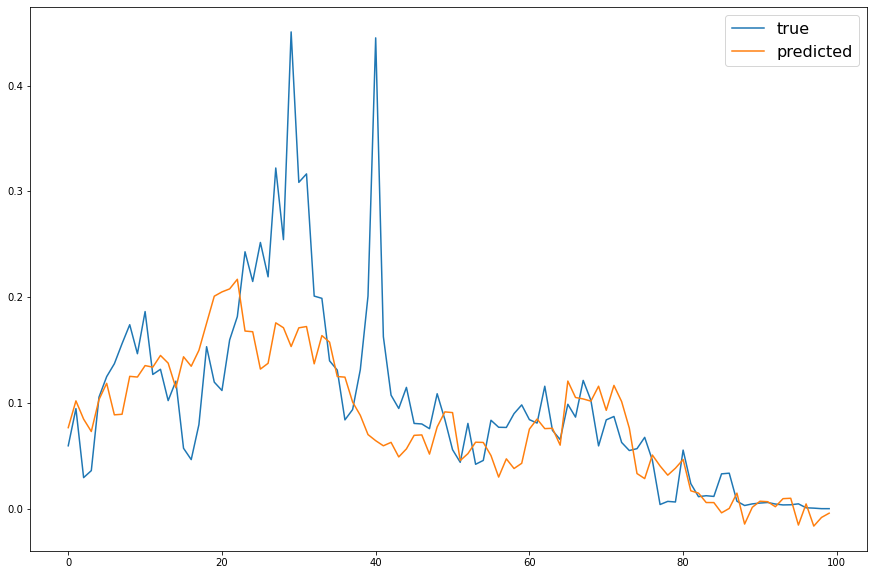

In [318]:
for example in dval.take(1):
    #print(example.shape)
    ex = example[0][random.randint(0,64)]
    print(ex.shape)
    print(ex.numpy().reshape(1,100,1).shape)
    plt.figure(figsize=(15,10))
    plt.plot(ex)
    plt.plot(vae.predict(ex.numpy().reshape(1,100,1)).flatten())
    plt.legend(['true', "predicted"], fontsize=16)
    

Text(0.5, 1.0, 'Predicting from random vector')

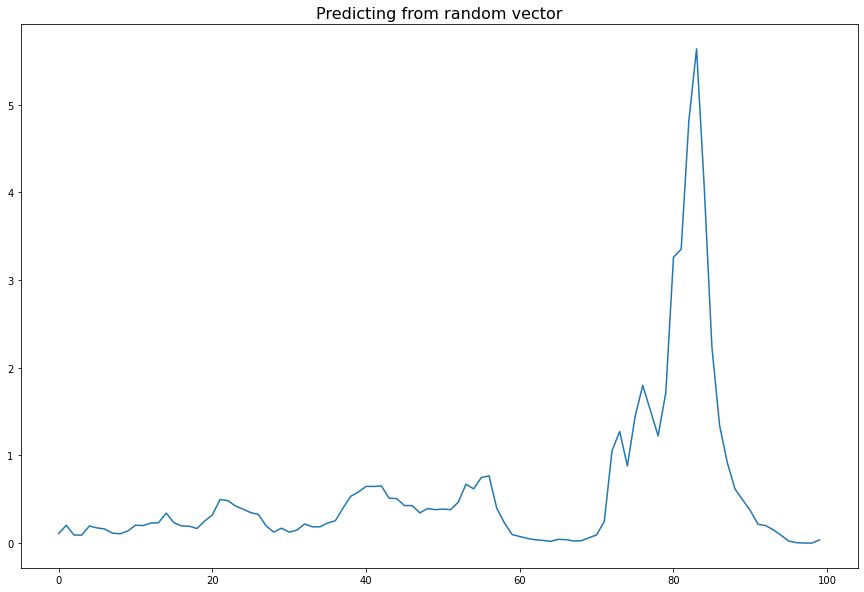

In [354]:
plt.figure(figsize=(15,10))
plt.plot(prob_decoder.predict((2*np.random.random((1,16,1))+1)).flatten())
plt.title("Predicting from random vector", fontsize=16)

<TakeDataset element_spec=(TensorSpec(shape=(64, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 100, 1), dtype=tf.float32, name=None))>

### Check learning curve

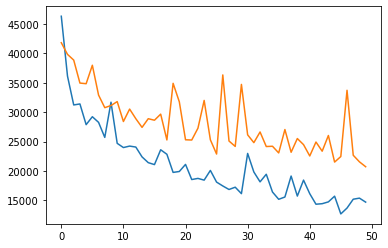

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

### Pass sample

Feed a dataset sample to the network and visualize output

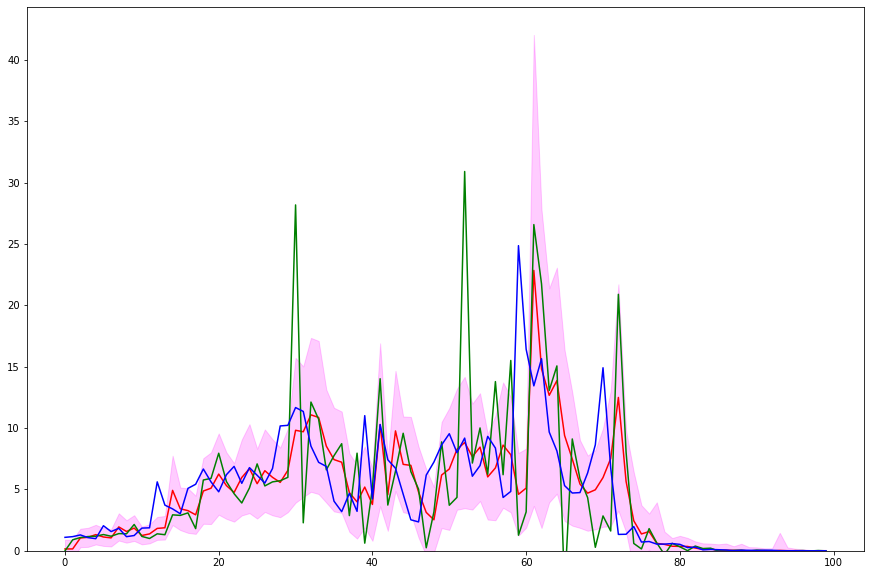

In [184]:
import random
sample = list(dset.take(100))[random.randint(3,100)]
samp_mean, samp_std, p_sample = pass_sample(pixel_cnn, sample['SFR_Max'])
plt.figure(figsize=(15,10))
std = samp_std.numpy().reshape((-1,))
mean = samp_mean.numpy().reshape((-1,))
plt.plot(mean,'r')
plt.fill_between(np.linspace(0,99,100,endpoint=True), y1=mean+std, y2=mean-std, color='magenta', alpha=0.2)
plt.plot(p_sample.numpy().reshape((-1,)), 'g')
plt.plot(sample['SFR_Max'].numpy().reshape((-1,)), 'b')
plt.ylim(bottom=0.0)
plt.show()

### Predictor

A randomly generated SFR from the model

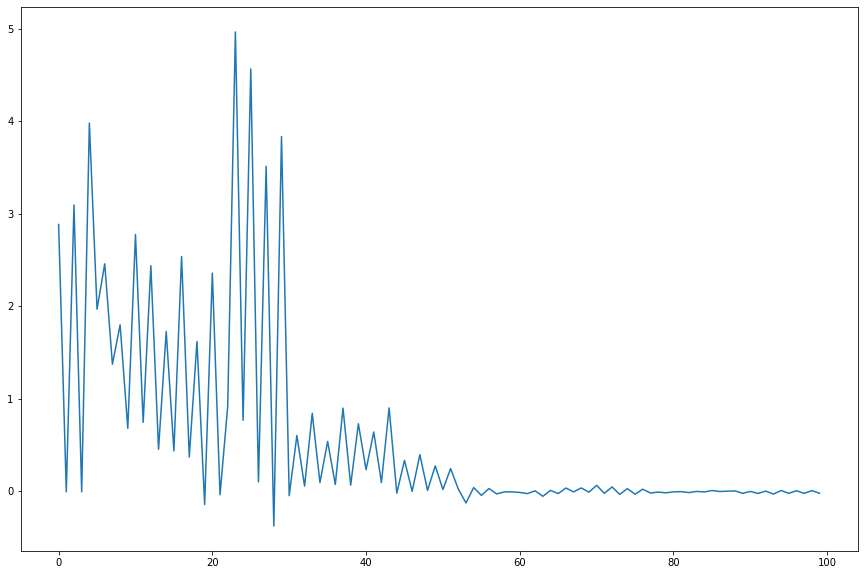

In [190]:
gen_sample = predictor(pixel_cnn, 1).reshape((-1,))
plt.figure(figsize=(15,10))
plt.plot(gen_sample)
plt.show()


### Finish sample

Take a part of a SFR sequence, and predicts the endplt.plot(sample['SFR_Max'].numpy().reshape((-1,)), 'b')

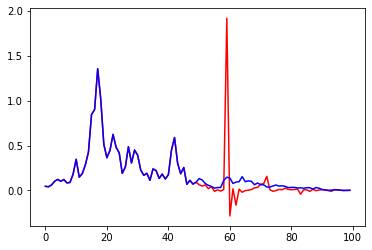

In [14]:
# TODO FIX MEEE
import importlib
import sys
sys.path.insert(0,'../sfh')
import model_utils
importlib.reload(model_utils)

gen_sample = model_utils.finish_sample(pixel_cnn, sample['SFR_Max'][:50]).reshape((-1,))
plt.plot(gen_sample, 'r')
plt.plot(sample['SFR_Max'].numpy().reshape((-1,)), 'b')
plt.show()


In [17]:
"""
## Build the model based on the original paper
"""

inputs = keras.Input(shape=(28,1))
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

#out = keras.layers.Conv1D(
#    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
#)(x)

out = tfp.layers.MixtureNormal(num_components, event_shape)(x)


pixel_cnn = keras.Model(inputs, out)

negloglik = lambda y, q: -q.log_prob(y)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss=negloglik)

pixel_cnn.summary()

In [52]:
from tensorflow.keras.utils import plot_model

plot_model(pixel_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
pixel_cnn.fit(
    x=data, y=data, batch_size=128, epochs=50, validation_split=0.1, verbose=2
)


In [ ]:
"""
## Demonstration
The PixelCNN cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.
"""

from IPython.display import Image, display

# Create an empty array of pixels.
batch = 4
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )



In [ ]:

def deprocess_image(x):
    # Stack the single channeled black and white image to rgb values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(Image("generated_image_0.png"))
display(Image("generated_image_1.png"))
display(Image("generated_image_2.png"))
display(Image("generated_image_3.png"))

In [159]:
l = 1
print(pixel_cnn.layers[l].input_shape)
print(pixel_cnn.layers[l].conv.kernel.get_shape())

(None, 100, 1)
(3, 1, 16)


[autoreload of sfh.models.pixelcnn_res failed: Traceback (most recent call last):
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/laatu/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/var/home/laatu/anaconda3/envs/tf-hack/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_fr

(1, 16, 16)


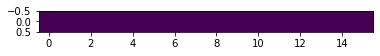

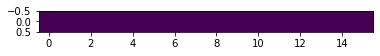

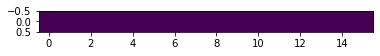

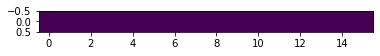

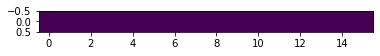

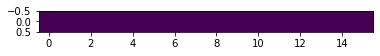

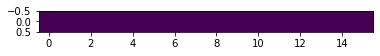

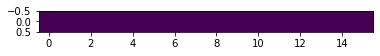

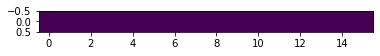

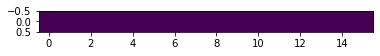

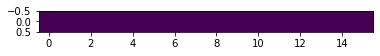

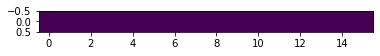

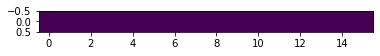

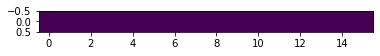

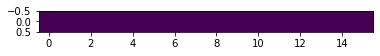

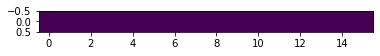

In [151]:
filt = np.ones(shape=pixel_cnn.layers[3].kernel.get_shape() )
print(filt.shape)
filt[-1,...] = 0
for i in range(16):
    plt.imshow(filt[...,i], vmin=0, vmax=1)
    plt.show()


In [ ]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

In [ ]:
for i in range(3):
    plt.imshow(filt[i], vmin=-1, vmax=1)
    plt.show()